In [1]:
import sys
import time
import pickle
import warnings
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from loguru import logger as log
from datetime import datetime
from collections import Counter
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from ialovecoffe.data import *
from ialovecoffe.models import *
from ialovecoffe.validation import computer_scores, computer_scores_outlier, accuracy_per_class
from sklearn.utils import shuffle
from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import roc_auc_score

In [53]:
# config
warnings.simplefilter("ignore")
random.seed(10)


def test_balacing(X, Y, percentage, rs, at='target', sm=False):
    
    X[at] = Y

    size_minority = min(Counter( X[at]).values())
    
    p = np.ceil(size_minority * percentage).astype('int')
    train = []
    test = []
    for classe in X[at].unique():
        
        df_class = X[X[at] == classe]
        
        test.append(df_class.iloc[:p])
        train.append(df_class.iloc[p:])
        
    df_train = pd.concat(train)
    df_test = pd.concat(test)

    # surffle
    df_train = shuffle(df_train, random_state=rs)
    df_test = shuffle(df_test, random_state=rs)
    
    y_train = df_train[at]
    y_test = df_test[at]
        
    x_train = df_train.drop([at], axis=1)
    x_test = df_test.drop([at], axis=1)   
    
    return x_train, y_train, x_test, y_test


def roc_calc_viz(classifier, X_test, y_test):
    viz = RocCurveDisplay.from_estimator(
                classifier,
                X_test,
                y_test
            )
    
    return viz.fpr, viz.tpr, viz.roc_auc

def roc_calc_viz_pred(y_true, y_pred):
    viz = RocCurveDisplay.from_predictions(
                            y_true,
                            y_pred
                        )

    return viz.fpr, viz.tpr, viz.roc_auc


def run_experiment(x, y, iterations, p, dsetname) -> pd.DataFrame:

    data_results = []

    results = {'model_name': [], 'iteration':[], 'F1':[], 
                'ROC':[],'acc-class-1':[],'acc-class-2':[], 'SEN':[], 
                'SPE':[], 'MCC':[], 'TPR': [], 'FPR':[], 'AUC': []}
    MD = None
    FOLD = None
    best = 0
    
    for i in tqdm(range(iterations)):

        x_train, y_train, x_test, y_test = test_balacing(x, y, 0.1, i)
        FOLD = [x_train, y_train, x_test, y_test]
        x_train = x_train.to_numpy()
        x_test = x_test.to_numpy()
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()

        log.debug('-' * 30)
        log.debug(f'{dsetname} - Iteration {i} - test size: {p}')
        log.debug('-' * 30)

       
        y_pred, y_pred_prob, model = RSDT(x_train, y_train, x_test, y_test)
        sen, spe, f1, roc, jac, fmi, mcc, fpr, tpr, thresh = computer_scores(y_test, y_pred, y_pred_prob)
        acc1, acc2 = accuracy_per_class(y_test, y_pred)
        viz_fpr, viz_tpr, viz_auc = roc_calc_viz_pred(y_test, y_pred_prob[:,1])
        results['model_name'].append('DecisionTree')
        results['iteration'].append(i)
        results['acc-class-1'].append(acc1)
        results['acc-class-2'].append(acc2)
        results['F1'].append(f1)
        results['ROC'].append(roc)
        results['SEN'].append(sen)
        results['SPE'].append(spe)
        results['MCC'].append(mcc)
        results['FPR'].append(viz_fpr)
        results['TPR'].append(viz_tpr)
        results['AUC'].append(viz_auc)
        log.debug(f'DT .......: {f1}')
        
        # if MD, FOLD
        if f1 > best:
            best = f1
            MD = model
            FOLD = [x_train, y_train, x_test, y_test]
 
    df_fold = pd.DataFrame(results)
    models = df_fold['model_name'].unique()
    log.info('\n')
    log.info('-' * 30)
    for model in models:

        df_model = df_fold[df_fold['model_name'] == model]
        mean_f1 = float(f'{np.mean(df_model["F1"]):.2f}')

        log.info(f'MODEL {model} with .....: {mean_f1}')

    return df_fold, MD, FOLD

In [54]:
x, y = read_C_type_I_vs_Type_II_no_PE_v4()

y.replace(to_replace=["Type_I", "Type_II"], value=[0, 1], inplace=True)

  0%|                                                                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]2022-07-20 18:56:06.344 | DEBUG    | __main__:run_experiment:76 - ------------------------------
2022-07-20 18:56:06.345 | DEBUG    | __main__:run_experiment:77 - C - Iteration 0 - test size: 0.1
2022-07-20 18:56:06.346 | DEBUG    | __main__:run_experiment:78 - ------------------------------
2022-07-20 18:56:07.952 | DEBUG    | __main__:run_experiment:97 - DT .......: 0.82857
  2%|████▎                                                                                                                                                                                                                     | 1/50 [00:01<01:19,  1.62s/it]2022-07-20 18:56:07.965 | DEBUG    | __main__:run_experiment:76 - ------------------------------
2022-07-20 18:56

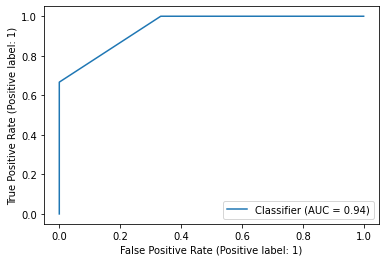

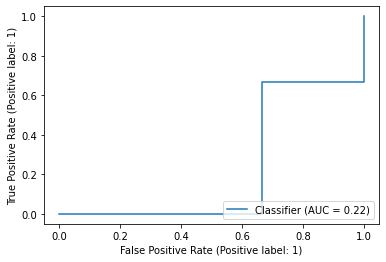

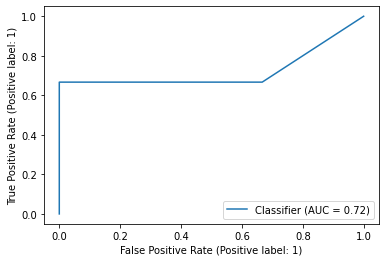

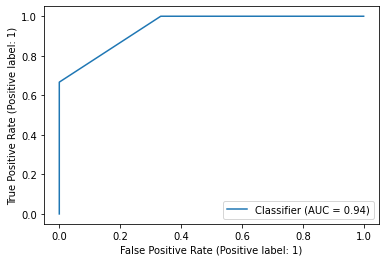

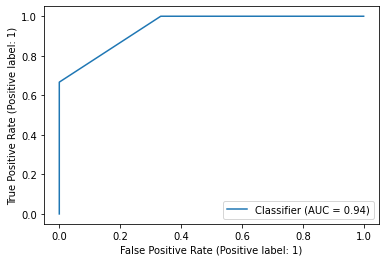

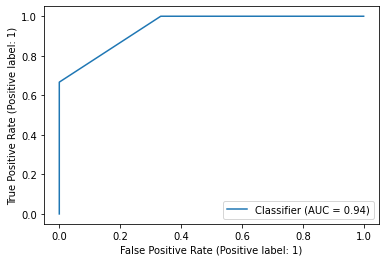

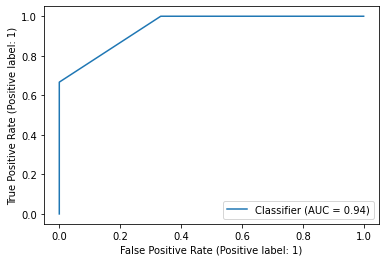

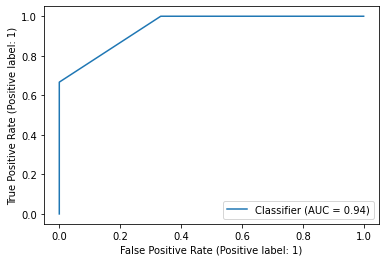

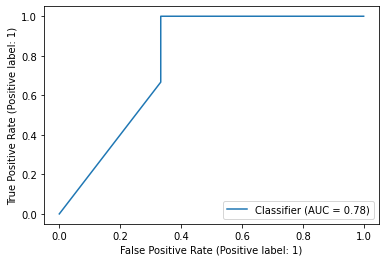

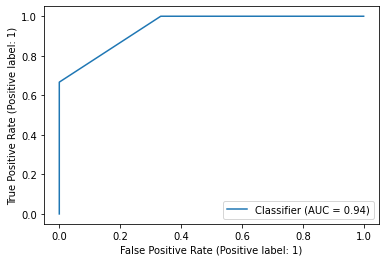

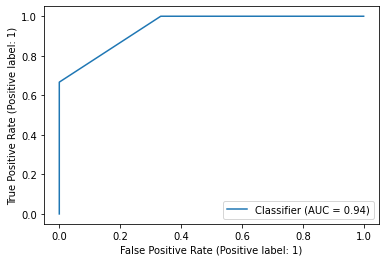

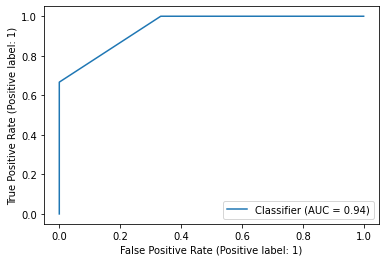

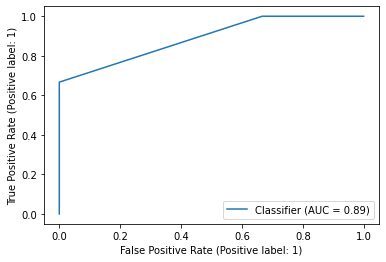

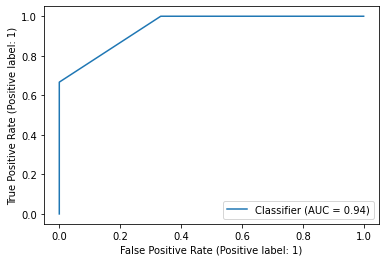

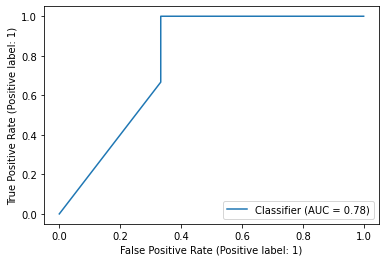

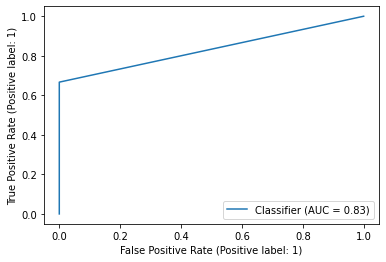

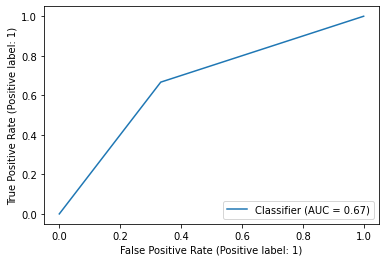

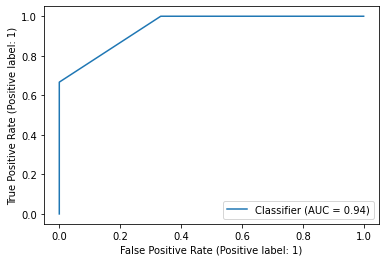

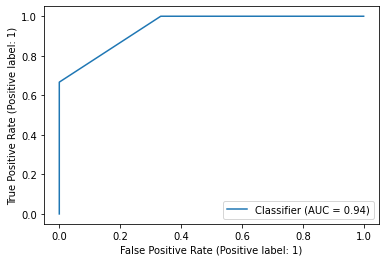

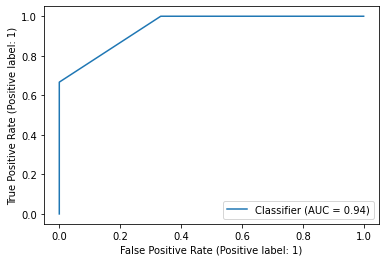

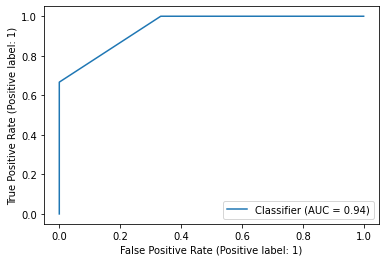

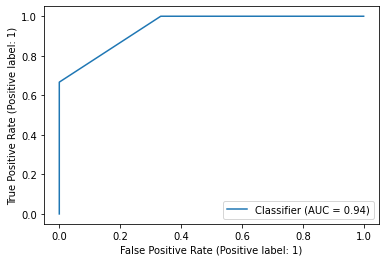

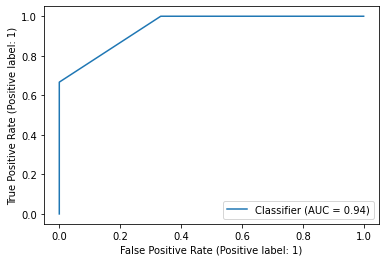

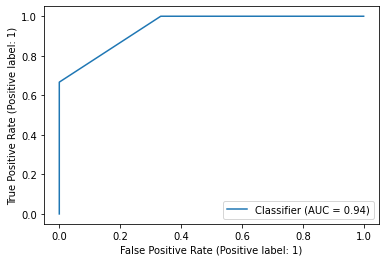

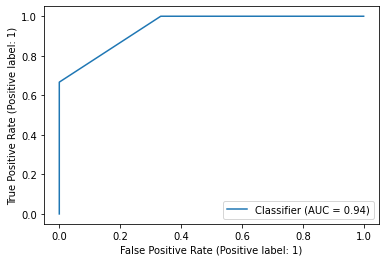

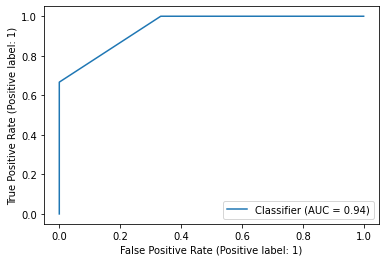

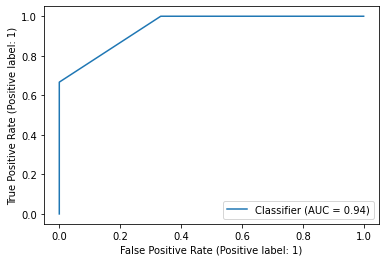

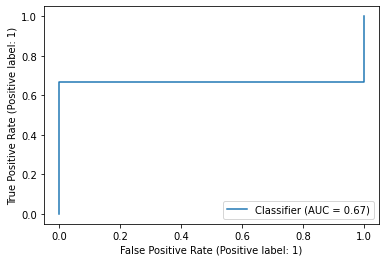

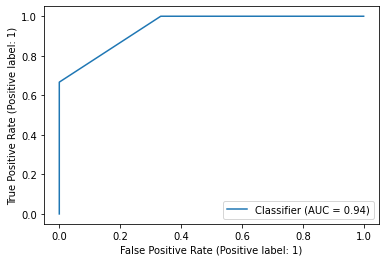

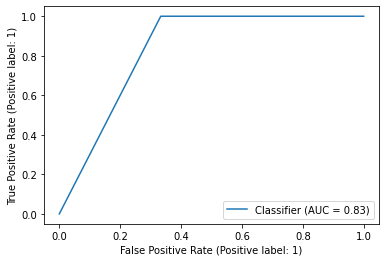

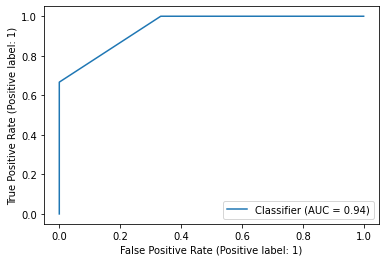

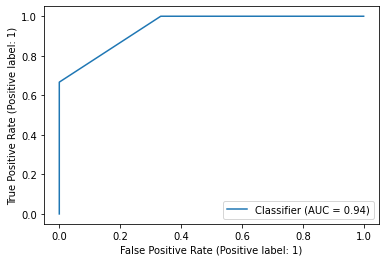

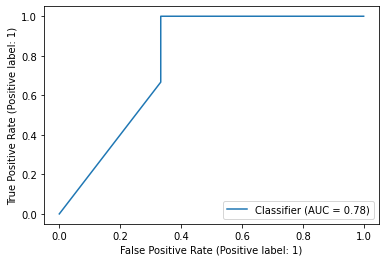

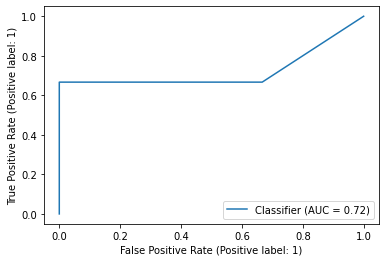

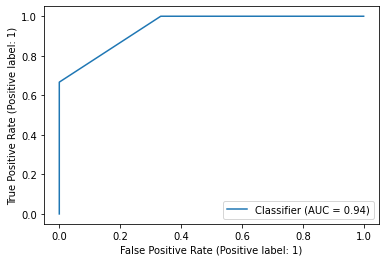

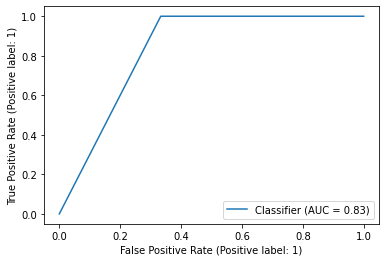

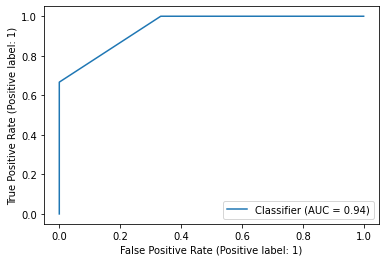

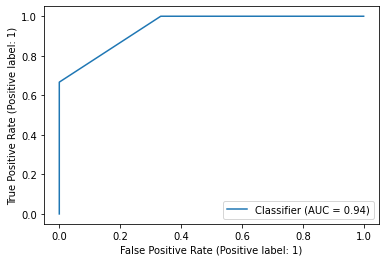

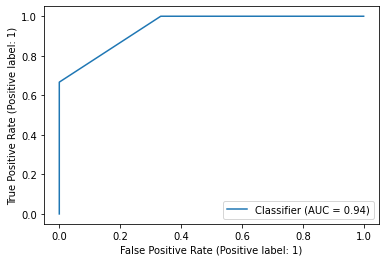

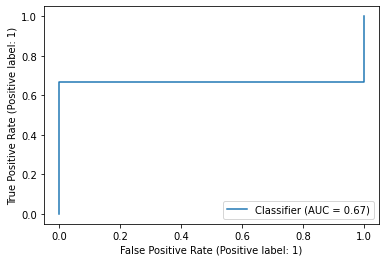

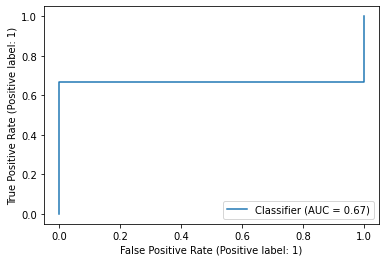

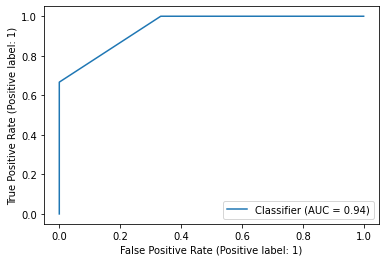

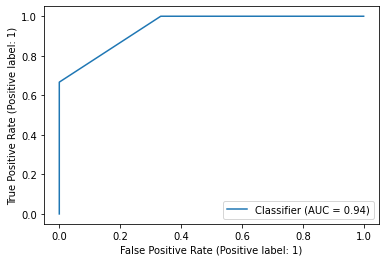

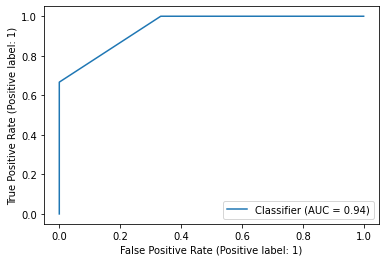

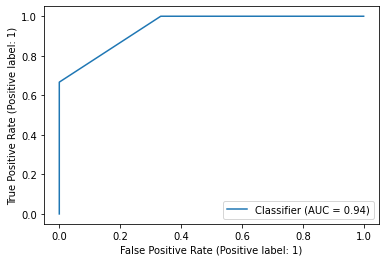

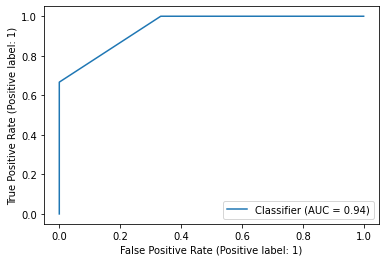

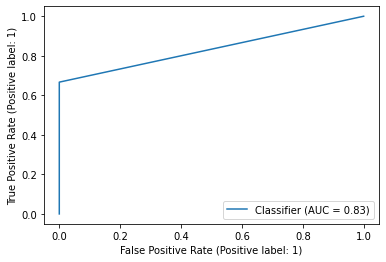

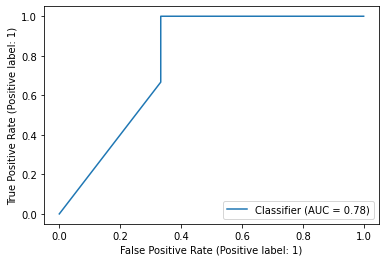

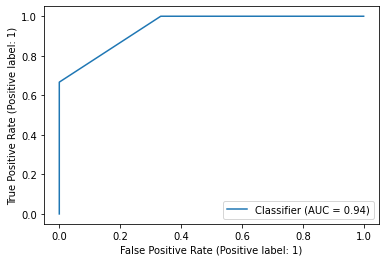

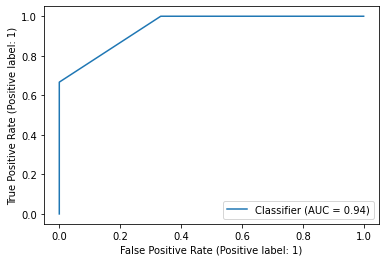

In [56]:
df, clf, fold = run_experiment(x, y, 50, 0.1, 'C')

In [59]:
x_train, y_train, x_test, y_test = fold

In [57]:
import shap
from alibi.explainers import KernelShap
shap.initjs()

In [64]:
dir(clf)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_features_

In [75]:
explainer = shap.TreeExplainer(clf.best_estimator_)

In [119]:
y_test

1    0
2    0
3    0
4    1
0    1
5    1
Name: target, dtype: int64

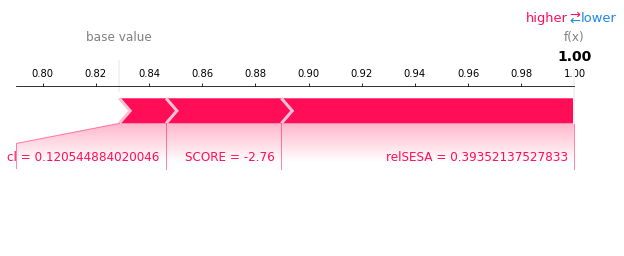

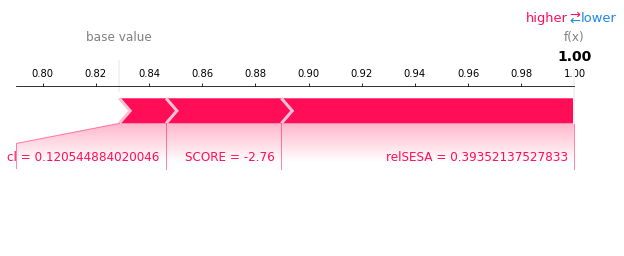

In [120]:
idx = 1
shap_values = explainer.shap_values(x_test.iloc[idx,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test.iloc[idx,:], matplotlib=True, show=False, figsize=(10, 3))
#plt.savefig('shap/att_erro_acerto.png', dpi=500)
#plt.savefig('shap/att_erro_acerto.png', dpi=500)
#plt.savefig('shap/att_erro_acerto.png', dpi=300)

In [118]:
shap_values = explainer.shap_values(x_test)
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test, show=False, figsize=(10, 3))
plt.savefig('shap/att_todo_test.png', dpi=300)

<Figure size 432x288 with 0 Axes>

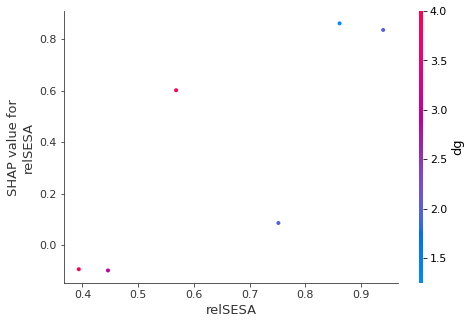

In [41]:
shap.dependence_plot('relSESA', shap_values[1], x_test)

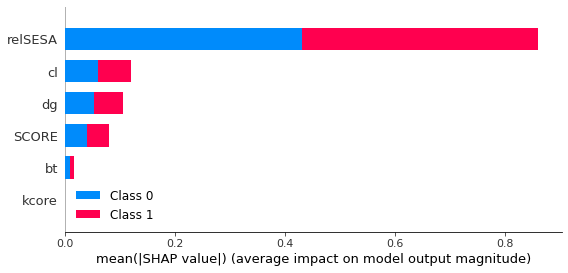

In [42]:
shap.summary_plot(shap_values, x_train)

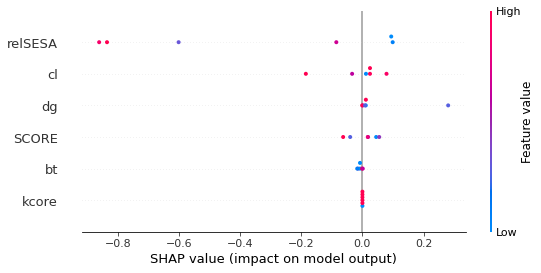

In [50]:
shap.summary_plot(explainer.shap_values(x_test)[0], 
                  x_test, 
                  x_train.columns, 
                  show=False)

In [51]:
from sklearn import tree

[Text(0.6666666666666666, 0.95, 'X[4] <= 0.821\ngini = 0.284\nsamples = 111\nvalue = [92, 19]'),
 Text(0.5, 0.85, 'X[5] <= -1.985\ngini = 0.221\nsamples = 103\nvalue = [90, 13]'),
 Text(0.3333333333333333, 0.75, 'X[4] <= 0.472\ngini = 0.13\nsamples = 86\nvalue = [80, 6]'),
 Text(0.16666666666666666, 0.65, 'X[4] <= 0.116\ngini = 0.075\nsamples = 77\nvalue = [74, 3]'),
 Text(0.1111111111111111, 0.55, 'gini = 0.0\nsamples = 43\nvalue = [43, 0]'),
 Text(0.2222222222222222, 0.55, 'X[4] <= 0.126\ngini = 0.161\nsamples = 34\nvalue = [31, 3]'),
 Text(0.16666666666666666, 0.45, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.2777777777777778, 0.45, 'X[5] <= -5.265\ngini = 0.114\nsamples = 33\nvalue = [31, 2]'),
 Text(0.2222222222222222, 0.35, 'X[5] <= -5.455\ngini = 0.375\nsamples = 8\nvalue = [6, 2]'),
 Text(0.16666666666666666, 0.25, 'X[1] <= 0.006\ngini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(0.1111111111111111, 0.15, 'X[0] <= 4.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0

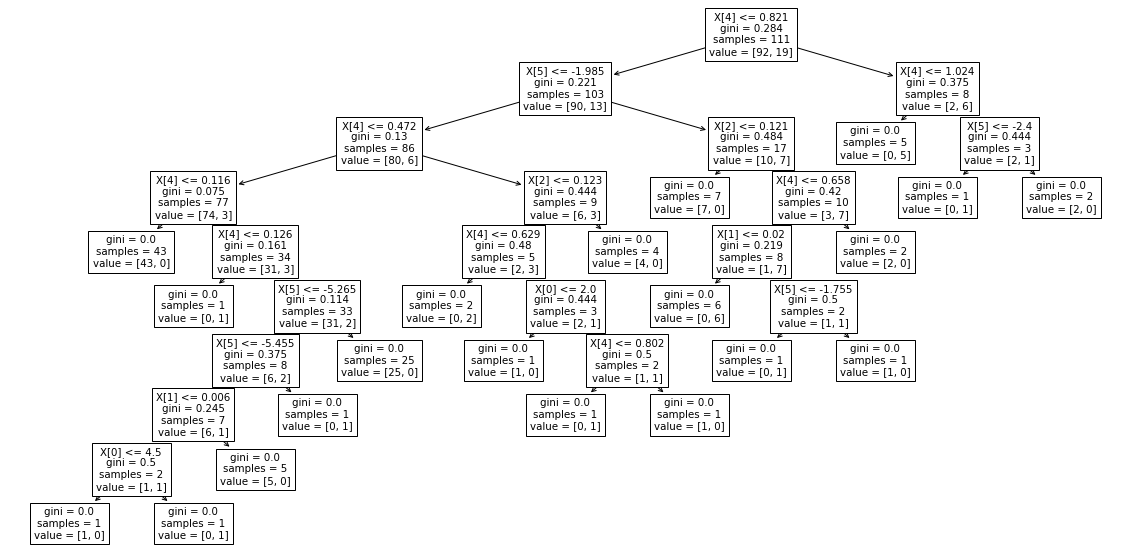

In [52]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf)